In [2]:
import kagglehub

path = kagglehub.dataset_download("yuvrajkari7/cancer-prediction-stage1")

100%|██████████| 3.82G/3.82G [00:45<00:00, 89.4MB/s]

Extracting files...


In [3]:
import os
print(os.listdir(path))

['stage 1']


In [4]:
stage1_path = os.path.join(path, "stage 1")
print(os.listdir(stage1_path))

['train', 'test']


In [5]:
train_dir = os.path.join(stage1_path, "train")
test_dir  = os.path.join(stage1_path, "test")

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 32001 images belonging to 2 classes.
Found 8001 images belonging to 2 classes.


In [7]:
print(train_data.class_indices)

{'benign': 0, 'cancer': 1}


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_stage1 = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),

    Dense(1, activation="sigmoid")   # binary output
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model_stage1.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_stage1.fit(
    train_data,
    validation_data=test_data,
    epochs=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 462s 455ms/step - accuracy: 0.6353 - loss: 0.8640 - val_accuracy: 0.6707 - val_loss: 0.7002


In [10]:
model_stage1.save("cancer_stage1_model.keras")

In [11]:
loss, accuracy = model_stage1.evaluate(test_data)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

251/251 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.8599 - loss: 0.6267
Test Loss: 0.7002
Test Accuracy: 0.6707


In [13]:
import numpy as np

y_true = test_data.classes              # actual labels
y_pred_prob = model_stage1.predict(test_data)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

251/251 ━━━━━━━━━━━━━━━━━━━━ 30s 117ms/step


In [14]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[3758  242]
 [2393 1608]]


In [15]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=["Benign (Normal)", "Malignant (Cancer)"]
))

                    precision    recall  f1-score   support

   Benign (Normal)       0.61      0.94      0.74      4000
Malignant (Cancer)       0.87      0.40      0.55      4001

          accuracy                           0.67      8001
         macro avg       0.74      0.67      0.65      8001
      weighted avg       0.74      0.67      0.65      8001



In [16]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_true, y_pred_prob)
print(f"ROC-AUC Score: {auc:.4f}")

ROC-AUC Score: 0.7750


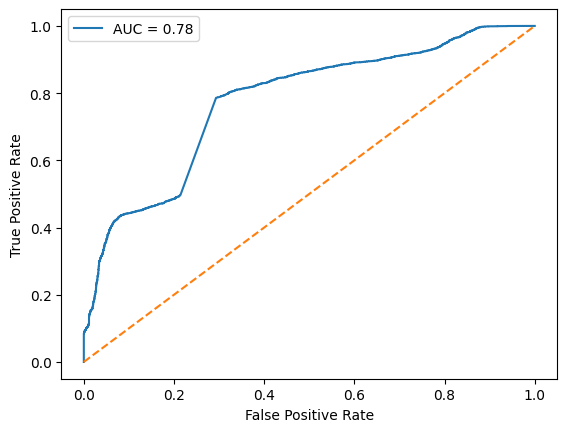

In [17]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()